In [65]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, cohen_kappa_score, precision_score
import sys
sys.path.append('../func')
from wrapper_rasterio import vectorize_raster
from cross_validation import CrossValidation

plt.rcParams.update({'font.size':12})

Load the index images and labels

In [66]:
# Indices
ECARR_2019 = rasterio.open('data/image/ECARR_Albany_2019.tif').read(1)
ECARR_2020 = rasterio.open('data/image/ECARR_Albany_2020.tif').read(1)
NDVI_2019 = rasterio.open('data/image/NDVI_Albany_2019.tif').read(1)
NDVI_2020 = rasterio.open('data/image/NDVI_Albany_2020.tif').read(1)

# Labels
label_gov_forcode = rasterio.open('data/label/ind_for20_Albany_28350_forcode.tif').read(1)
label_Eucalypt_gov = (34 <= label_gov_forcode) & (label_gov_forcode <= 48)
label_Plantation_gov_hard = label_gov_forcode == 91
label_Plantation_gov_soft = label_gov_forcode == 92
label_Plantation_gov_mixed = label_gov_forcode == 93
label_NonEucalypt_gov = ~((label_gov_forcode == 0) | label_Eucalypt_gov | label_Plantation_gov_hard | label_Plantation_gov_soft | label_Plantation_gov_mixed)

label_Eucalypt_Oji = rasterio.open('data/label/Oji_plant_150km.tif').read(1)
label_Pine = rasterio.open('data/label/Pine_mod_150km.tif').read(1)

label_Plantation_all = label_Plantation_gov_hard | label_Plantation_gov_soft | label_Plantation_gov_mixed | (label_Eucalypt_Oji==1) | (label_Pine ==1)

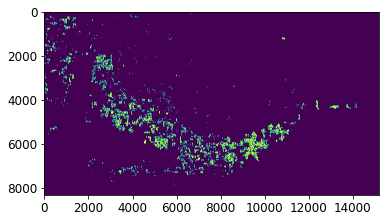

In [48]:
plt.imshow(label_Plantation_gov_hard)
plt.show()

# Distribution check

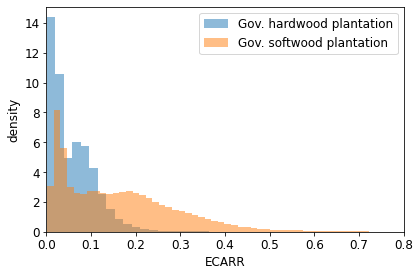

In [50]:
plt.hist(ECARR_2019[label_Plantation_gov_hard & (ECARR_2019 < 2)], density=True, alpha=0.5, bins=100, label='Gov. hardwood plantation')
plt.hist(ECARR_2019[label_Plantation_gov_soft & (ECARR_2019 < 2)], density=True, alpha=0.5, bins=100, label='Gov. softwood plantation')
plt.legend()
plt.xlabel('ECARR')
plt.ylabel('density')
plt.xlim(0,0.8)
plt.tight_layout()
# plt.savefig('figure/dist_gov_exp.png')
plt.show()

There are two modes in the distributions:  
* Left mode --> Bare ground
* Right mode --> Planted (vegetated) area

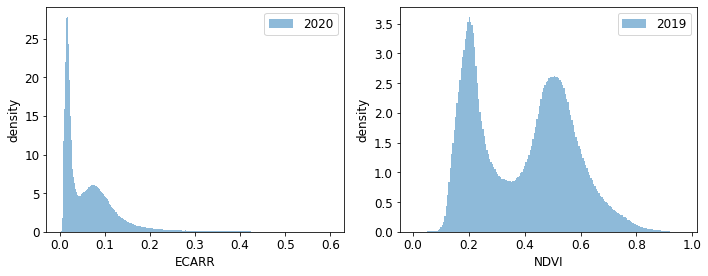

In [59]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.hist(ECARR_2019[label_Plantation_all & (ECARR_2019 < 0.6)], density=True, alpha=0.5, bins=300, label='2020')
plt.legend()
plt.xlabel('ECARR')
plt.ylabel('density')
# plt.xlim(0,0.8)
plt.tight_layout()

plt.subplot(122)
# plt.hist(NDVI_2020[label_Plantation_all & (NDVI_2020 > 0)], density=True, alpha=0.5, bins=200, label='2020')
plt.hist(NDVI_2019[label_Plantation_all & (NDVI_2019 > 0)], density=True, alpha=0.5, bins=200, label='2019')
# plt.xlim(0.3,0.5)
# plt.legend()
plt.xlabel('NDVI')
plt.ylabel('density')
plt.legend()
plt.tight_layout()
plt.show()

Set the thresholds to remove the bare ground pixels

In [60]:
thr_bareground_NDVI = 0.40
# thr_bareground_NDVI = 0.25

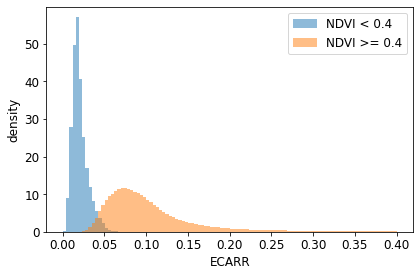

In [61]:
ind_lower = label_Plantation_all & (NDVI_2019 < thr_bareground_NDVI) & (ECARR_2019 < 0.4)
ind_upper = label_Plantation_all & (NDVI_2019 >= thr_bareground_NDVI) & (ECARR_2019 < 0.4)
plt.hist(ECARR_2019[ind_lower], density=True, alpha=0.5, bins=100, label=f'NDVI < {thr_bareground_NDVI}')
plt.hist(ECARR_2019[ind_upper], density=True, alpha=0.5, bins=100, label=f'NDVI >= {thr_bareground_NDVI}')
plt.legend()
plt.xlabel('ECARR')
plt.ylabel('density')
plt.tight_layout()
# plt.savefig('figure/ECARR_on_NDVI.png')
plt.show()

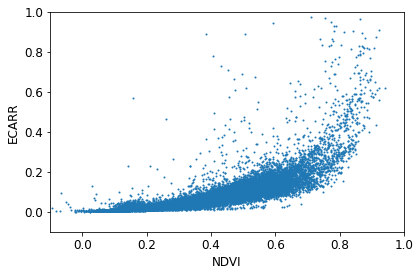

In [34]:
# NDVI vs ECARR
mask_valid = (ECARR_2019 < 2) & label_Plantation_all
ind_show = np.random.choice(np.arange(mask_valid.sum()),replace=False, size=50000)
plt.scatter(NDVI_2019[mask_valid][ind_show], ECARR_2019[mask_valid][ind_show],s=1)
# plot = sns.kdeplot(NDVI_2020[mask_valid][ind_show], ECARR_2020[mask_valid][ind_show])
plt.xlabel('NDVI')
plt.ylabel('ECARR')
plt.xlim(-0.1,1.0)
plt.ylim(-0.1,1.0)
plt.tight_layout()
# plt.savefig('figure/scatter_NDVI_ECARR.png')
plt.show()

In [64]:
# # Overlap analysis between the gov data and Oji GT

# label_intersection_hard = (label_Eucalypt_Oji == label_Plantation_gov_hard) & label_Eucalypt_Oji
# coverage_hard = label_intersection_hard.sum() / label_Eucalypt_Oji.sum()

# label_intersection_soft = (label_Eucalypt_Oji == label_Plantation_gov_soft) & label_Eucalypt_Oji
# coverage_soft = label_intersection_soft.sum() / label_Eucalypt_Oji.sum()

# label_intersection_mixed = (label_Eucalypt_Oji == label_Plantation_gov_mixed) & label_Eucalypt_Oji
# coverage_mixed = label_intersection_mixed.sum() / label_Eucalypt_Oji.sum()

# print(coverage_hard)
# print(coverage_soft)
# print(coverage_mixed)

# Regression analysis

In [54]:
mask_valid_2019 = (ECARR_2019 < 2) & (NDVI_2019 >= thr_bareground_NDVI)

# X_hard = ECARR_2019[mask_valid_2019 & label_Plantation_gov_hard & (label_Eucalypt_Oji != 1) & (label_Pine != 1)]
# X_soft = ECARR_2019[mask_valid_2019 & label_Plantation_gov_soft & (label_Eucalypt_Oji != 1) & (label_Pine != 1)]
X_hard = ECARR_2019[mask_valid_2019 & label_Plantation_gov_hard]
X_soft = ECARR_2019[mask_valid_2019 & label_Plantation_gov_soft]
n_hard = len(X_hard)
n_soft = len(X_soft)
n_all = n_hard + n_soft
X = np.concatenate([X_hard, X_soft]).reshape(-1,1)
y = np.zeros(len(X), dtype=np.int8)
y[:n_hard] = 1

## Cross validation

Run a cross validation using the government data to find the optimal hyper-parameter   
(the threshold for the output of the logistic regression model).  
Because the training data are imbalanced, the resampling of negative labels (softwood plantation) is done during the cross validation.

In [42]:
n_folds = 10
np.random.seed(99)
ind = np.random.choice(np.arange(n_all), size = 50000, replace = False)
X_cv = X[ind]
y_cv = y[ind]

cv = CrossValidation(X_cv, y_cv, n_folds, resample_range=[1,5])
res = cv.calculate(p_upper=0.8, evaluation='f1_score')
res.to_csv('result/result_cv.csv', index=False)

In [55]:
res = pd.read_csv('result/result_cv.csv')
n_resample = int(res.ratio.max() - res.ratio.min() + 1)
res_mean = res.groupby(['ratio']).mean().drop(['i_cv','support'],axis=1)
res_mean

,thr,precision,recall,f1-score,accuracy,kappa
ratio,,,,,,
1.0,0.6500,0.920917,0.976541,0.947908,0.905108,0.420568
2.0,0.4550,0.920877,0.976454,0.947846,0.905000,0.420020
3.0,0.3450,0.920685,0.976853,0.947932,0.905124,0.419147
4.0,0.2775,0.920549,0.976895,0.947878,0.905016,0.418016
5.0,0.2275,0.920178,0.977396,0.947918,0.905044,0.415781


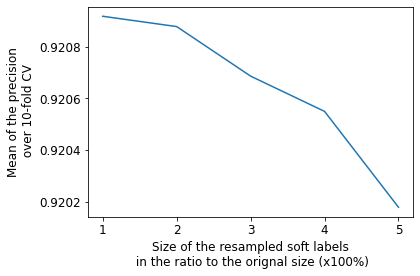

In [56]:
plt.rcParams["font.size"] = 12
xx = np.arange(1,n_resample+1)
metric = 'precision'
yy = res_mean.loc[:,metric].values
plt.plot(xx,yy)
plt.xticks(xx)
plt.xlabel('Size of the resampled soft labels\n in the ratio to the orignal size (x100%)')
plt.ylabel(f'Mean of the {metric}\n over {n_folds}-fold CV')
# plt.legend()
plt.tight_layout()
# plt.savefig('fig/f1_regression_cle.png')
plt.show()

## Training and prediction for the Oji plantation area

Train the model using the whole data

In [57]:
r_resample = 1  # Size of resampling chosen by CV

index_train = np.arange(n_all)
index_train_hard = index_train[y == 1]
index_train_soft = index_train[y == 0]
index_train_soft_rs = np.random.choice(index_train_soft, replace=True, size=r_resample*len(index_train_soft))
index_train_rs = np.concatenate([index_train_soft_rs, index_train_hard])
X_train_rs, y_train_rs = X[index_train_rs], y[index_train_rs]
clf = LogisticRegression()
model = clf.fit(X_train_rs, y_train_rs)

Apply the trained model to the Oji plantation area

In [58]:
thr_best = res_mean.loc[r_resample, 'thr']  # the probability threshold chosen by CV

# Masks
mask_valid_2020 = (ECARR_2020 < 2) & (NDVI_2020 > thr_bareground_NDVI)
label_bareground_2020 = label_Plantation_all & (NDVI_2020 < thr_bareground_NDVI)

# Output for all plantation sites
X_full = ECARR_2020[mask_valid_2020 & label_Plantation_all].reshape(-1,1)
prediction_full = model.predict_proba(X_full)[:,1] > thr_best
pred_map = 255 * np.ones_like(label_Eucalypt_Oji, dtype=np.int8)
pred_map[mask_valid_2020 & label_Plantation_all] = prediction_full

# Calculate the performance on Oji GT
X_oji_eucalypt = ECARR_2020[mask_valid_2020 & (label_Eucalypt_Oji == 1)]
X_oji_pine = ECARR_2020[mask_valid_2020 & (label_Pine == 1)]
X_oji = np.concatenate([X_oji_eucalypt, X_oji_pine]).reshape(-1,1)
n_oji = len(X_oji)
y_oji = np.zeros(n_oji, dtype=np.int8)
y_oji[:len(X_oji_eucalypt)] = 1
y_oji_pred = model.predict_proba(X_oji)[:,1] > thr_best
score_all = classification_report(y_oji,y_oji_pred,output_dict=True,zero_division=1)

print('Performance on the Oji GT')
print(score_all['1'])

Performance on the Oji GT
{'precision': 0.9970224447361974, 'recall': 0.9880721894006835, 'f1-score': 0.9925271399269598, 'support': 160633}


Output the prediction map as a geojson file

In [109]:
map_0 = vectorize_raster((pred_map==0), reference='data/label/Oji_plant_150km.tif')
map_1 = vectorize_raster((pred_map==1), reference='data/label/Oji_plant_150km.tif')
map_2 = vectorize_raster(label_bareground_2020, reference='data/label/Oji_plant_150km.tif')

map_0['class'] = 0 # Eucalyptus
map_1['class'] = 1 # Non eucalyptus
map_2['class'] = 2 # Bare ground
map_export = map_0.append(map_1).append(map_2)
map_export = map_export.set_crs('EPSG:28350')
map_export.to_file('result/pred_map.geojson',driver='GeoJSON')

In [25]:
# Cleaned version where small isolated eucalyptus pixels are removed
Areas = map_export.geometry.apply(lambda x: x.area)
ind_small = Areas <= 400
map_export_clean = map_export.loc[~ind_small]
map_export_clean.to_file('result/pred_map_clean.geojson',driver='GeoJSON')